# **Cluster Insight extraction and Fitting Pareto Model**

## Objectives

1. Compute descriptive stats for clusters
2. Create visualisations
3. Draw insights
4. Fit and validate the Pareto/Power Law model for conflict severity 

## Inputs

- df_full_with_labels.csv

## Outputs

1. Visualisations
2. Set of conflict cluster insights

## Additional Comments

<ins>Why fitting a Pareto/Power Law model?</ins>

Conflict fatalities are not distributed normally: most events cause few deaths, while a small number cause extremely high casualties. A power-law (Pareto) distribution may capture this imbalance by modeling how ***rare, catastrophic events dominate the overall dynamics of violence***.

Confirming whether fatalities follow the power-law is important because:
1. It reveals the risk structure of violent conflict
2. Identifies scale-free dynamics, i.e. if severe conflicts follow the power law, then the same mechanisms may apply accross scales (e.g. skirmishes, major battles, regional wars)
3. May guide further modelling and scenario planning

<ins> In Short:</ins> Conflict fatalities follow a heavy-tailed distribution, meaning rare, extreme events play a disproportionate role; modeling this with a Pareto/power-law distribution helps explain the underlying structure and risk profile of violent conflict.


In [27]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import powerlaw

In [3]:
# load data
df_clean = pd.read_csv(Path.cwd().parent / 'data/clean/acled_clean.csv')
df_input = pd.read_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index_col=0)

# Cluster insights

To reduce writing redundancy, all insights will be summarised at the end of this section, rather than bit by bit.

 => SKIP to ***Insights Summary***

In [6]:
# add labels to original clean data

# load full dataset with clusters
df_input_whole = pd.read_csv(Path.cwd().parent / 'models/df_full_with_clusters.csv', index_col=0)
# select only labels and event id from full dataset with clusters
df_clusters = df_input_whole.reset_index()[["event_id_cnty", "cluster"]]
df_clusters.head()

# load original clean data
df_clean = pd.read_csv(Path.cwd().parent / 'data/clean/acled_clean.csv')

# merge clusters with original clean data
df = df_clean.merge(
    df_clusters,
    on="event_id_cnty",
    how="left"
)

df.head()

,event_id_cnty,event_type,sub_event_type,interaction,region,country,latitude,longitude,geo_precision,source_scale,fatalities,population_best,cluster
0,MMR1,Violence against civilians,Attack,State forces-Civilians,Asia,Myanmar,16.0408,98.1232,2,National,0,7592.0,11.0
1,SOM5580,Battles,Armed clash,Political militia-Political militia,Africa,Somalia,2.2524,44.6905,1,National,7,26203.0,17.0
2,BGD7238,Battles,Armed clash,Political militia-Political militia,Asia,Bangladesh,24.4577,89.7080,1,International,0,82027.0,-1.0
3,ETH1319,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5091,39.4437,2,International,10,23950.0,0.0
4,ETH1320,Battles,Armed clash,State forces-External/Other forces,Africa,Ethiopia,14.5219,39.3850,2,International,10,23950.0,0.0


In [8]:
# as all rows with geo_precision < 3 were removed during clustering, check for any missing clusters
df.isnull().sum()

event_id_cnty          0
event_type             0
sub_event_type         0
interaction            0
region                 0
country                0
latitude               0
longitude              0
geo_precision          0
source_scale           0
fatalities             0
population_best        0
cluster            20309
dtype: int64

In [9]:
# drop rows with missing clusters
df.dropna(subset=["cluster"], inplace=True)

## Basic cluster descriptive statistics

In [10]:
# view cluster sizes
cluster_counts = df["cluster"].value_counts().sort_index()

print("Cluster sizes:")
print(cluster_counts)

Cluster sizes:
cluster
-1.0       2038
 0.0     253774
 1.0      92633
 2.0       5287
 3.0     210117
 4.0      59989
 5.0     145362
 6.0      17228
 7.0      34887
 8.0      32406
 9.0      31278
 10.0     41769
 11.0     38230
 12.0     17386
 13.0     12099
 14.0      7219
 15.0      7342
 16.0      6128
 17.0     16013
 18.0      4084
 19.0       857
 20.0       209
 21.0       486
 22.0       442
 23.0        97
 24.0      1751
 25.0       280
 26.0       496
 27.0       572
 28.0       151
 29.0      1628
 30.0        88
 31.0        24
 32.0        57
 33.0       330
 34.0       356
 35.0       345
 36.0       569
 37.0       152
 38.0       137
 39.0       176
 40.0       135
 41.0        93
 42.0        31
 43.0        65
 44.0        73
 45.0        23
 46.0        19
Name: count, dtype: int64


In [11]:
# there are 47 clusters (0 to 46) plus noise (-1) of various sizes
# selecting the top 15 largest will be most cost-effective for analysis

# identify top 15 clusters by size
top_clusters = (
    df["cluster"]
    .value_counts()
    .head(15)
    .index
)

# filter dataframe to only include top clusters
df_top = df[df["cluster"].isin(top_clusters)].copy()

df_top['cluster'].value_counts()    

cluster
0.0     253774
3.0     210117
5.0     145362
1.0      92633
4.0      59989
10.0     41769
11.0     38230
7.0      34887
8.0      32406
9.0      31278
12.0     17386
6.0      17228
17.0     16013
13.0     12099
15.0      7342
Name: count, dtype: int64

In [12]:
# group clusters by fatality
fatality_stats_raw = (
    df_top.groupby("cluster")["fatalities"]
    .agg(["count", "mean", "median", "std"])
    .sort_index()
)

# round statistics
fatality_stats_raw['mean'] = fatality_stats_raw['mean'].round(3)
fatality_stats_raw['std'] = fatality_stats_raw['std'].round(3)

fatality_stats_raw.head(15)

,count,mean,median,std
cluster,,,,
0.0,253774,2.605,0.0,8.465
1.0,92633,1.098,1.0,1.150
3.0,210117,1.329,0.0,4.837
4.0,59989,1.066,1.0,3.993
5.0,145362,0.503,0.0,3.788
6.0,17228,2.558,1.0,10.904
7.0,34887,1.827,1.0,5.872
8.0,32406,0.976,1.0,1.463
9.0,31278,2.180,0.0,6.082


In [13]:
# event type composition per cluster 
event_distribution = (
    df_top.groupby("cluster")["event_type"]
          .value_counts(normalize=True)
          .unstack(fill_value=0)
          .sort_index()
)

# format columns
for col in range(event_distribution.shape[1]):
    event_distribution.iloc[:, col] = event_distribution.iloc[:, col].round(4)

event_distribution

event_type,Battles,Explosions/Remote violence,Violence against civilians
cluster,,,
0.0,0.9997,0.0003,0.0000
1.0,0.0002,0.0002,0.9996
3.0,0.0001,0.9998,0.0001
4.0,0.0003,0.0004,0.9993
5.0,0.0003,0.9995,0.0002
6.0,0.0000,0.0044,0.9956
7.0,0.0003,0.0003,0.9995
8.0,0.9989,0.0011,0.0000
9.0,0.9979,0.0021,0.0000


In [14]:
# obtain most defining (i.e. mode) interaction type per cluster
top_interactions = (
    df_top.groupby("cluster")["interaction"]
    .agg(lambda x: x.value_counts().index[0])
)

top_interactions

cluster
0.0                State forces-Rebel group
1.0             Political militia-Civilians
3.0                       State forces only
4.0             Political militia-Civilians
5.0              External/Other forces only
6.0              Identity militia-Civilians
7.0                   Rebel group-Civilians
8.0          State forces-Political militia
9.0                 Rebel group-Rebel group
10.0                 Political militia only
11.0                 State forces-Civilians
12.0    Political militia-Political militia
13.0      Identity militia-Identity militia
15.0    Political militia-Political militia
17.0    Political militia-Political militia
Name: interaction, dtype: object

In [15]:
# geographical spread
region_distribution = (
    df_top.groupby("cluster")["region"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# format columns
for col in range(region_distribution.shape[1]):
    region_distribution.iloc[:, col] = region_distribution.iloc[:, col].round(3)
    
region_distribution

region,Africa,Americas,Asia,Europe,Middle East
cluster,,,,,
0.0,0.231,0.0,0.362,0.218,0.188
1.0,0.000,1.0,0.000,0.000,0.000
3.0,0.105,0.0,0.186,0.191,0.518
4.0,0.511,0.0,0.313,0.020,0.156
5.0,0.003,0.0,0.005,0.615,0.377
6.0,0.867,0.0,0.101,0.001,0.031
7.0,0.631,0.0,0.156,0.000,0.213
8.0,0.000,1.0,0.000,0.000,0.000
9.0,0.347,0.0,0.145,0.000,0.508


In [16]:
# population density
density_distribution = (
    df_top.groupby("cluster")["population_best"]
    .agg(["median"])
    .sort_index()
)

# round statistics
density_distribution['median'] = density_distribution['median'].round(3)

density_distribution

,median
cluster,
0.0,5799.0
1.0,82549.0
3.0,4443.0
4.0,26203.0
5.0,1537.0
6.0,12079.5
7.0,8159.0
8.0,136259.0
9.0,7045.0


In [17]:
# source scale distribution
source_scale_distribution = (
    df_top.groupby("cluster")["source_scale"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# format columns
for col in range(source_scale_distribution.shape[1]):
    source_scale_distribution.iloc[:, col] = source_scale_distribution.iloc[:, col].round(3)
    
source_scale_distribution

source_scale,International,Local/Subnational,National,New media,Other,Regional
cluster,,,,,,
0.0,0.046,0.239,0.305,0.027,0.345,0.038
1.0,0.001,0.495,0.453,0.001,0.048,0.001
3.0,0.044,0.281,0.291,0.032,0.284,0.068
4.0,0.062,0.262,0.555,0.029,0.078,0.014
5.0,0.004,0.157,0.381,0.036,0.414,0.007
6.0,0.046,0.315,0.565,0.028,0.029,0.017
7.0,0.058,0.395,0.310,0.112,0.116,0.009
8.0,0.002,0.525,0.473,0.000,0.000,0.000
9.0,0.075,0.335,0.238,0.049,0.279,0.025


In [18]:
# combine the above into a summary dataframe
cluster_summary = pd.DataFrame({
    "size": fatality_stats_raw["count"],
    "mean_fatalities": fatality_stats_raw["mean"],
    "median_fatalities": fatality_stats_raw["median"],
    "dominant_event_type": event_distribution.idxmax(axis=1),
    "dominant_interaction": top_interactions,
    "dominant_region": region_distribution.idxmax(axis=1),
    "median_population_density": density_distribution["median"],
    "dominant_source_scale": source_scale_distribution.idxmax(axis=1)
})

cluster_summary.head(15)

,size,mean_fatalities,median_fatalities,dominant_event_type,dominant_interaction,dominant_region,median_population_density,dominant_source_scale
cluster,,,,,,,,
0.0,253774,2.605,0.0,Battles,State forces-Rebel group,Asia,5799.0,Other
1.0,92633,1.098,1.0,Violence against civilians,Political militia-Civilians,Americas,82549.0,Local/Subnational
3.0,210117,1.329,0.0,Explosions/Remote violence,State forces only,Middle East,4443.0,National
4.0,59989,1.066,1.0,Violence against civilians,Political militia-Civilians,Africa,26203.0,National
5.0,145362,0.503,0.0,Explosions/Remote violence,External/Other forces only,Europe,1537.0,Other
6.0,17228,2.558,1.0,Violence against civilians,Identity militia-Civilians,Africa,12079.5,National
7.0,34887,1.827,1.0,Violence against civilians,Rebel group-Civilians,Africa,8159.0,Local/Subnational
8.0,32406,0.976,1.0,Battles,State forces-Political militia,Americas,136259.0,Local/Subnational
9.0,31278,2.180,0.0,Battles,Rebel group-Rebel group,Middle East,7045.0,Local/Subnational


## Visual analysis

### Core cluster structure

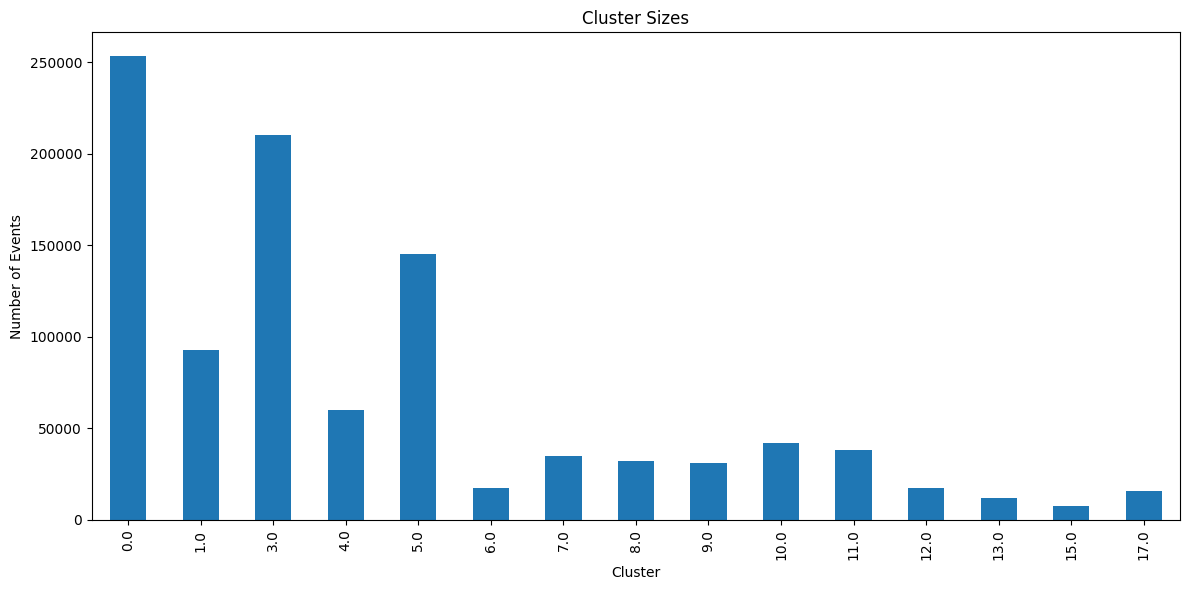

In [19]:
# 1 Cluster Size Bar Chart
# Scope: identify major vs minor clusters

plt.figure(figsize=(12,6))
cluster_summary["size"].plot(kind="bar")
plt.title("Cluster Sizes")
plt.ylabel("Number of Events")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

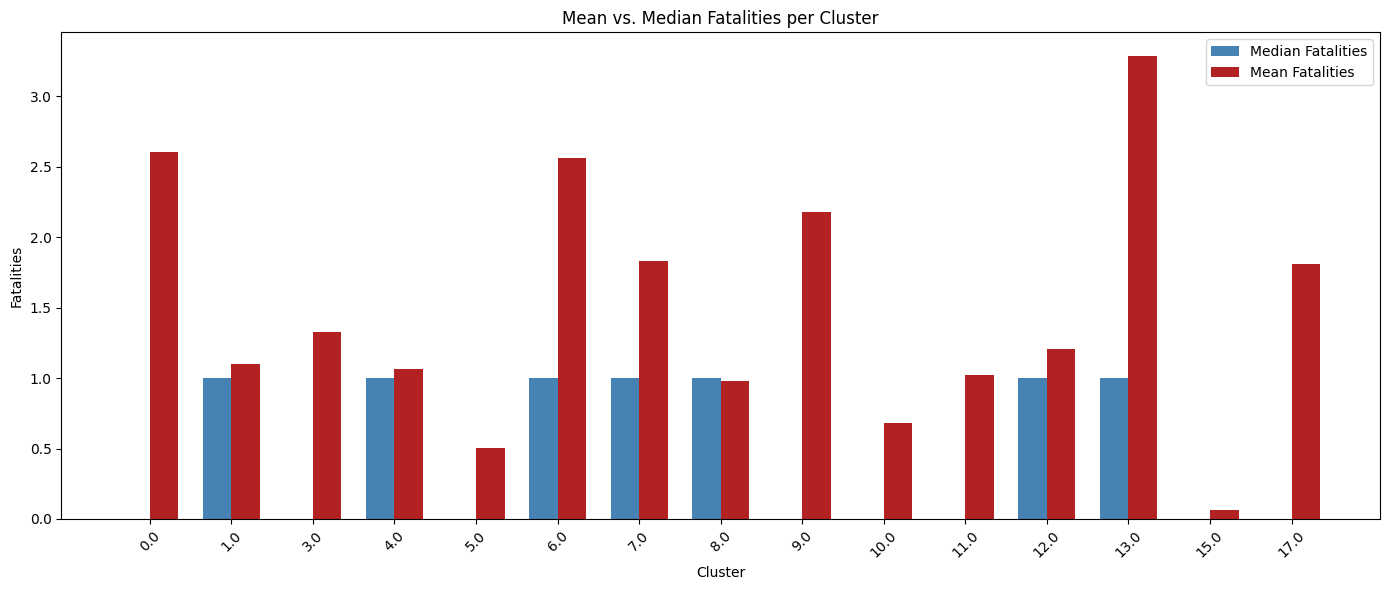

In [20]:
# 2 Fatalities 
# Scope: see which clusters are deadlier and detect outlier severity.

x = np.arange(len(cluster_summary.index.astype(str)))  
width = 0.35                      

plt.figure(figsize=(14,6))

# plot median (blue)
plt.bar(x - width/2, cluster_summary["median_fatalities"], width, label="Median Fatalities", color="steelblue")

# plot mean (red)
plt.bar(x + width/2, cluster_summary["mean_fatalities"], width, label="Mean Fatalities", color="firebrick")

# titles and labels
plt.title("Mean vs. Median Fatalities per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Fatalities")
plt.xticks(x, cluster_summary.index.astype(str), rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

### Cluster characterisation

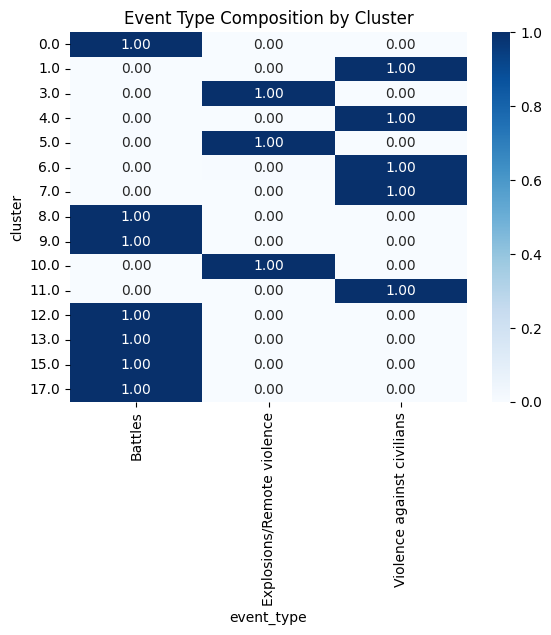

In [21]:
# 3 Event type Composition Heatmap
# Scope: identify battle-dominant vs. protest-dominant vs. civilian-targeted clusters

sns.heatmap(event_distribution, cmap="Blues", annot=True, fmt=".2f")
plt.title("Event Type Composition by Cluster")
plt.show()

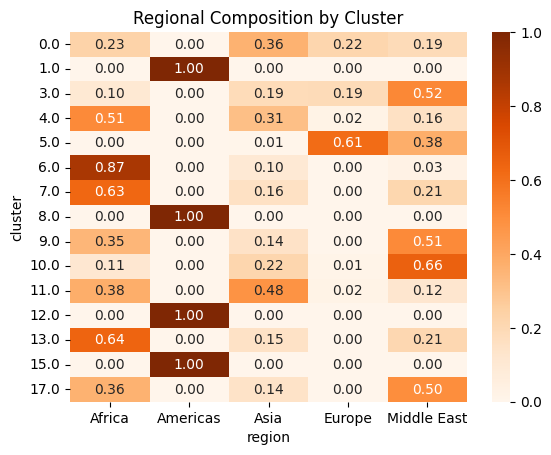

In [22]:
# 4 Region Composition Heatmap
# Scope: identify regional cluster patterns

sns.heatmap(region_distribution, cmap="Oranges", annot=True, fmt=".2f")
plt.title("Regional Composition by Cluster")
plt.show()

### Global summaries

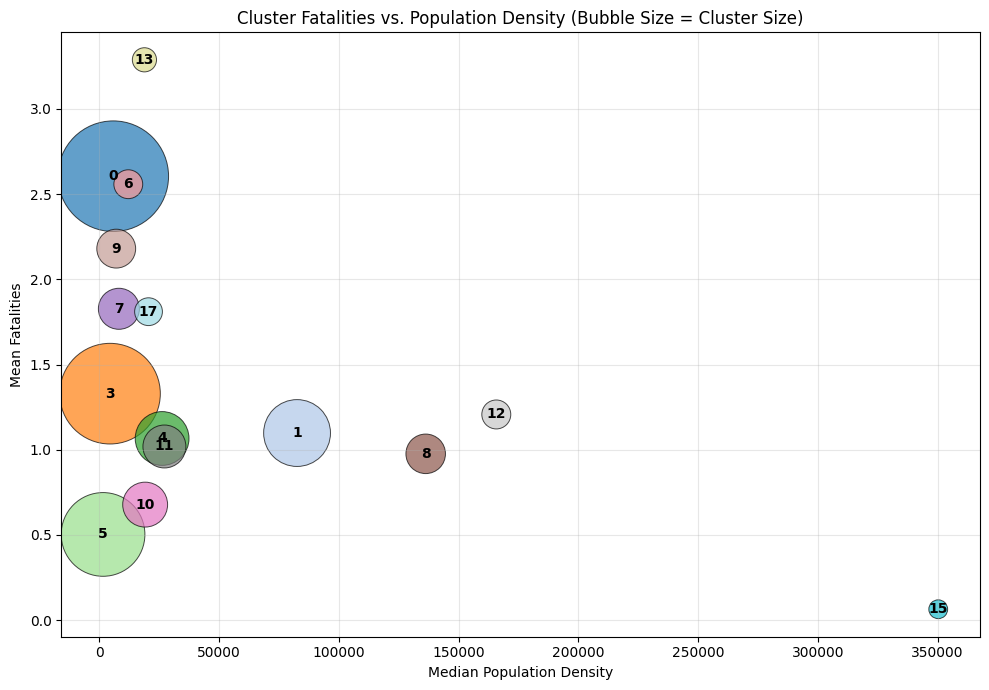

In [23]:
# 5 Population density vs Fatalities
# Scope: show whether conflict severity clusters correlate with civilian population density

x = cluster_summary["median_population_density"]
y = cluster_summary["mean_fatalities"]
sizes = cluster_summary["size"] / 40      
clusters = cluster_summary.index.astype(int)

# set colormap with distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_summary)))

plt.figure(figsize=(10, 7))

# create scatter plot with colors and adjust transparency
plt.scatter(
    x, y,
    s=sizes,
    c=colors,
    alpha=0.7,          # transparency
    edgecolor="black",  # add black outline
    linewidth=0.7
)

# add cluster labels directly on bubbles
for i, cluster in enumerate(clusters):
    plt.text(
        x.iloc[i], y.iloc[i],
        cluster,
        fontsize=10,
        ha="center",
        va="center",
        color="black",
        weight="bold"
    )

# labels and title
plt.xlabel("Median Population Density")
plt.ylabel("Mean Fatalities")
plt.title("Cluster Fatalities vs. Population Density (Bubble Size = Cluster Size)")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

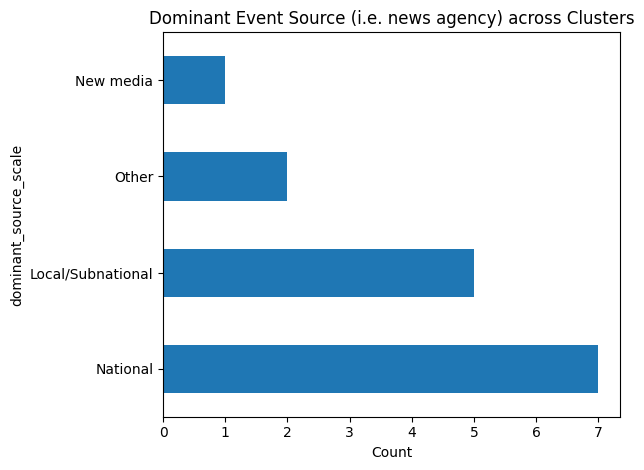

In [24]:
# 6 Source Scale Distribution Bar Chart
# Scope: demonstrate where ACLED information for each cluster comes from

cluster_summary["dominant_source_scale"].value_counts().plot(kind="barh")
plt.title("Dominant Event Source (i.e. news agency) across Clusters")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

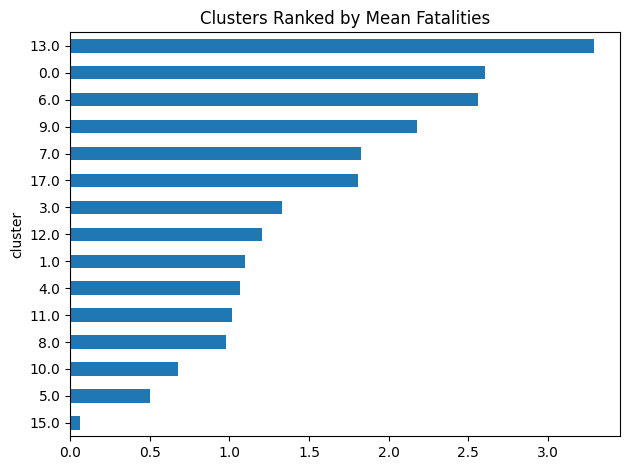

In [25]:
# 7 Cluster Severity Ranking Chart
# Scope: rank clusters by severity in a single, readable plot

cluster_summary["mean_fatalities"].sort_values().plot(kind="barh")
plt.title("Clusters Ranked by Mean Fatalities")
plt.tight_layout()
plt.show()

## Insights Summary

<ins>Note on cluster -1</ins>

This cluster represents noise or extreme outliers. Unlike other clustering techniques, DBSCAN does not force outliers into one of the main clusters, instead creates a special cluster for them.

Smaller clusters (Clusters 16–47) represent rare, localized, or low-density conflict patterns and are omitted for brevity.

<ins>**Cluster size**</ins>:
1. Major clusters: 0, 3, 5
2. Medium: 1, 4
3. Minor: 6, 7, 8, 9, 10, 11, 12, 13, 15, 17

<ins>**Cluster fatality**</ins>, mean-median comparison:
1. Low Mean-Median disparity => uniform fatality cluster
    - High fatality: 1, 4, 8, 12
    - Low fatality: 15
2. High Mean-Median disparity => outlier violence spikes
    - High fatality: 0, 6, 7, 9, 13, 17
    - Low fatality: 3, 5, 10, 11

<ins>**Event types**</ins>

1. Battle dominated: 0, 8, 9, 12, 13, 15, 17
2. Explosions/Remote violence: 3, 5, 10
3. Civilian violence: 1, 4, 6, 7, 11

<ins>**Fatality and Pop density**</ins>
- Most events (of all fatality rates) happen in sparsely populated regions
- Slight downwards linear trend => the more populated a region the fewer fatalities events tend to have

# Pareto Severity Analysis

In [28]:
# for the severity analysis, events with 0 fatalities will be excluded
fatalities = df["fatalities"]
fatalities = fatalities[fatalities > 0]

In [30]:
# fit the pareto / power-law model

fit = powerlaw.Fit(fatalities, discrete=True)
alpha = fit.power_law.alpha
xmin  = fit.power_law.xmin

print("Alpha (tail exponent):", alpha)
print("xmin (start of power-law behavior):", xmin)

Calculating best minimal value for power law fit
Alpha (tail exponent): 2.559854089363945
xmin (start of power-law behavior): 11.0


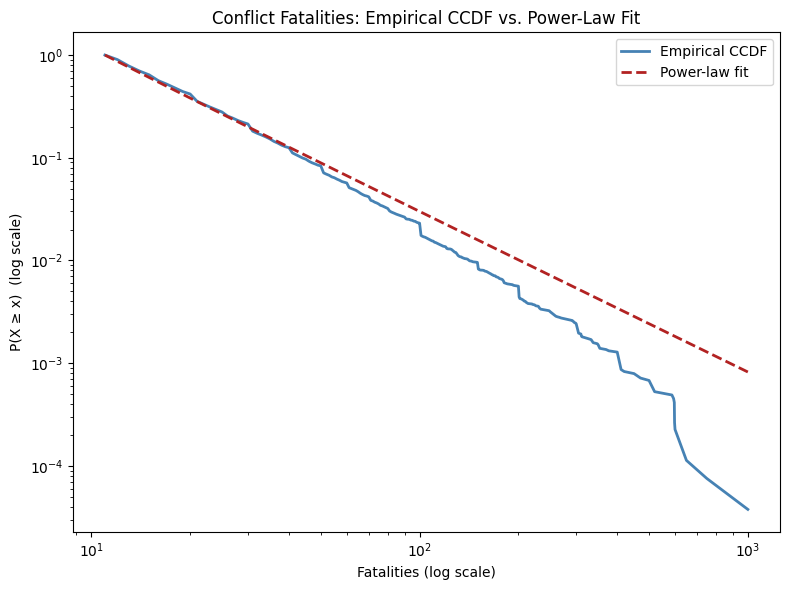

In [36]:
# create CCDF plots for empirical data and fitted power-law

# create a single axis to superimpose both plots
fig, ax = plt.subplots(figsize=(8,6))

# plot empirical CCDF on this axis
fit.plot_ccdf(ax=ax, color='steelblue', linewidth=2, label='Empirical CCDF')

# plot fitted power-law CCDF on the same axis
fit.power_law.plot_ccdf(ax=ax, color='firebrick', linestyle='--', linewidth=2, label='Power-law fit')

# set to log scale
ax.set_xscale('log')
ax.set_yscale('log')

# labels and title
ax.set_xlabel("Fatalities (log scale)")
ax.set_ylabel("P(X ≥ x)  (log scale)")
ax.set_title("Conflict Fatalities: Empirical CCDF vs. Power-Law Fit")

ax.legend()
plt.tight_layout()
plt.show()

Since the match is not perfect, compare it to other similarly shape distribution types.

In [38]:
# comparison with lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')
print("Power law vs lognormal: R =", R, ", p =", round(p, 5))

# comparison with exponential
R2, p2 = fit.distribution_compare('power_law', 'exponential')
print("Power law vs exponential: R =", R2, ", p =", round(p2, 5))

Power law vs lognormal: R = -168.58336241546942 , p = 0.0
Power law vs exponential: R = 3739.7483527366003 , p = 0.0


## Severity analysis conclusions

1. α = 2.55 implies:
    - Moderately heavy-tailed distribution, i.e. extreme events are rare but systematically present
    - Tail decays slower than true exponential, but faster than very heavy tails
    - Results are consistent with conflict literature, where α is between 2.4 and 2.7 usually
2. xmin = 11 fatalities:
    - Power-law behaviour holds only for events with **11+ fatalities**
    - Below the threshold there is a different distribution type
3. CCDF tapers off towards the end:
    - The Power-Law extropolates, but the real data cannot sustain infinite tails as real life events have natural constraints (population, geography etc.) 
    - Also, there are far fewer observations towards the higher fatalities end, becoming increasingly noisier
    - So for the most catastrophic events, fatalities deviate from a pure Power-Law
4. Versus Lognormal R = -168.6 and p < 0.00... implies:
    - Lognormal fits significantly better than power law in this case
    - Coroborates with xmin = 11 => overall, fatalities show heavy-tailed behaviour consistent with power-law scaling, but the lognormal distribution provides a significantly better fit to the observed tail due to the non-power law behaviour of the tail's end
5. Versus Exponential R = 3739.7 and p < 0.00... implies:
    - Power-Law fits significantly better than the exponential
    - This is mostly due to the slower-than-exponential decay of tail => extreme fatalities events are far more common than an exponential model would predict

<ins>Summary</ins>
Although the lognormal distribution provides the statistically best fit to the fatality data, the empirical CCDF exhibits a clear power-law–like regime above xmin = 11, with tail exponent α ≈ 2.55.
This indicates that conflict severity follows a heavy-tailed process: extreme events are rare but occur far more frequently than thin-tailed models (e.g., exponential) would predict.
Thus, the risk structure and strategic implications associated with Pareto-type behaviour remain valid even though the lognormal tail provides the closest mathematical description.